In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random


In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(1)

In [3]:
class Net(nn.Module):
    '''

    '''
    def __init__(self):
        super(Net, self).__init__()

        # convolution block 1        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.BatchNorm2d(8),


            nn.Conv2d(8, 8, 3),
            nn.ReLU(),
            nn.BatchNorm2d(8),

        )

        # convolution block 2
        self.conv_block_2 = nn.Sequential(

            nn.Conv2d(8, 8, 3),
            nn.ReLU(),
            nn.BatchNorm2d(8),

        )

        # transition block 1
        self.transition_1 = nn.Sequential(
           nn.Conv2d(in_channels= 8,out_channels= 6, kernel_size =1),
           nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # convolution block 3
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),


            nn.Conv2d(16, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),


            nn.Conv2d(16, 12, 3),

        
        )
        

        # fully connected
        self.fc1 = nn.Linear(25*12,10)


    def forward(self, x):

        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.transition_1(x)
        x = self.conv_block_3(x)
 

#       reshape using flatten
        x = torch.flatten(x, 1)

#       Fully connected layer
        x = self.fc1(x) # 1x1x25*12 -> 1x1x10


        x = x.view(-1, 10)

        return F.log_softmax(x,dim=-1)

In [4]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4            [-1, 8, 24, 24]             584
              ReLU-5            [-1, 8, 24, 24]               0
       BatchNorm2d-6            [-1, 8, 24, 24]              16
            Conv2d-7            [-1, 8, 22, 22]             584
              ReLU-8            [-1, 8, 22, 22]               0
       BatchNorm2d-9            [-1, 8, 22, 22]              16
           Conv2d-10            [-1, 6, 22, 22]              54
             ReLU-11            [-1, 6, 22, 22]               0
        MaxPool2d-12            [-1, 6, 11, 11]               0
           Conv2d-13             [-1, 16, 9, 9]             880
             ReLU-14             [-1, 1

In [6]:
#torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

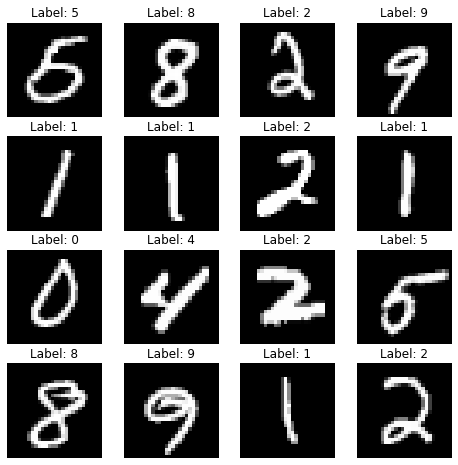

In [7]:
def show_batch(dl):
    images, labels = next(iter(dl))
    plt.figure(figsize=(8, 8))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        ax.imshow(torch.squeeze(images[i], axis=0), cmap='gray')
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')

show_batch(train_loader)

In [8]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    correct = 0
    model.train()
    pbar = tqdm(train_loader)
    per_batch_loss = []

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        pred = output.argmax(dim=1, keepdim=True)          
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = F.nll_loss(output, target)
        per_batch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
#        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

    
    per_epoch_loss = sum(per_batch_loss)/len(per_batch_loss)
    per_epoch_accuracy = 100.*( correct / len(train_loader.dataset))
    
    return per_epoch_loss, per_epoch_accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    #     test_loss, correct, len(test_loader.dataset),
    #     100. * correct / len(test_loader.dataset)))


    return test_loss , 100. * correct / len(test_loader.dataset)


In [9]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.9) 


loss_train = []
accuracy_train = []
loss_test = []
accuracy_test = []
epochs = 15

for epoch in range(0, epochs):
    print('============== EPOCH ', epoch)
    loss_train_epoch,accuracy_train_epoch = train(model, device, train_loader, optimizer, epoch)
    loss_test_epoch, accuracy_test_epoch = test(model, device, test_loader)
    
    loss_train.append(loss_train_epoch)
    accuracy_train.append(accuracy_train_epoch)

    loss_test.append(loss_test_epoch)
    accuracy_test.append(accuracy_test_epoch)

    print(f'\t Train accuracy : {accuracy_train_epoch} , Test Accuracy: {accuracy_test_epoch}')
    print(f'\t Train Loss: {loss_train_epoch} , Test Loss: {loss_test_epoch}')
    

def plot_loss(train_loss, test_loss):
    plt.figure(figsize=(8,6))
    plt.plot(np.linspace(1, epochs, epochs).astype(int),loss_train,'-x')
    plt.plot(np.linspace(1, epochs, epochs).astype(int),loss_test,'-x')
    plt.legend(['train_loss', 'test_loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')


def plot_accuracy(train_acc, test_acc):
    plt.figure(figsize=(8,6))
    plt.plot(np.linspace(1, epochs, epochs).astype(int),train_acc,'-x')
    plt.plot(np.linspace(1, epochs, epochs).astype(int),test_acc,'-x')
    plt.legend(['train_acc', 'test_acc'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')




  0%|          | 0/469 [00:00<?, ?it/s]	 Train accuracy : 95.03166666666667 , Test Accuracy: 98.3
	 Train Loss: 0.15935481396883028 , Test Loss: 0.051590331602096556
============== EPOCH  1
  0%|          | 0/469 [00:00<?, ?it/s]	 Train accuracy : 98.53166666666667 , Test Accuracy: 98.27
	 Train Loss: 0.04801962660081478 , Test Loss: 0.052259018754959106
============== EPOCH  2
  0%|          | 0/469 [00:00<?, ?it/s]	 Train accuracy : 98.81666666666666 , Test Accuracy: 98.96
	 Train Loss: 0.03835592177837515 , Test Loss: 0.032523392701148984
============== EPOCH  3
  0%|          | 0/469 [00:00<?, ?it/s]	 Train accuracy : 98.92999999999999 , Test Accuracy: 99.01
	 Train Loss: 0.033794038875429616 , Test Loss: 0.03321549224853516
============== EPOCH  4
  0%|          | 0/469 [00:00<?, ?it/s]	 Train accuracy : 99.125 , Test Accuracy: 99.02
	 Train Loss: 0.02827074012951429 , Test Loss: 0.03253543720245361
============== EPOCH  5
  0%|          | 0/469 [00:00<?, ?it/s]	 Train accuracy : 

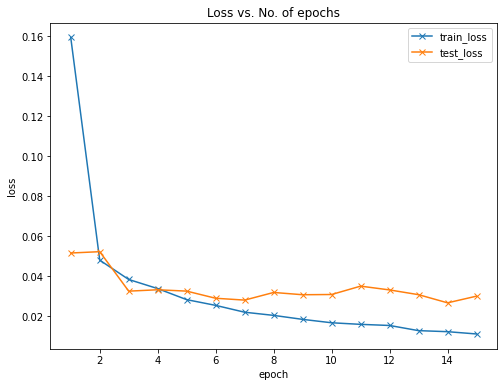

In [10]:
plot_loss(loss_train,loss_test)

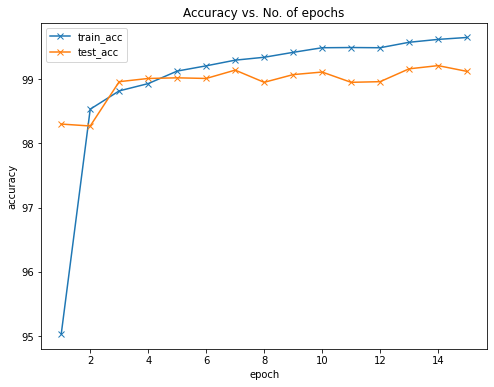

In [11]:
plot_accuracy(accuracy_train,accuracy_test)


Target:

        Get parameters model of just within 10k
        Epochs to 15
        
        
        
Info  :  

        Tried to get model below 10k parameters 
        Using fully connected layer for now, to establish a baseline

Results:  

        Parameters: 9.3k  
        Best Training Accuracy: 99.64 
        Best Test Accuracy: 99.21

Analysis:  
        
        The model is overfitting, as clearly seen at last epoch with accuracy of 99.64
 
       The only possible updates for test accuracy were ~ 100-99.64 =~ 0.04 , which would have got test accuracy to         99.25 at best case.

       Hence we need to reduce capacity of model, which we will try in next iteration.


